In [1]:
from lib_linear import *
import time
import torch.nn.functional as F
from copy import deepcopy

## read diagonalized iinput-input, input-output and output-output matrices

In [2]:
input_input_matrix = np.array(pd.read_csv('input_input_matrix.csv'))
output_input_matrix = np.array(pd.read_csv('output_input_matrix.csv'))
output_output_matrix = np.array(pd.read_csv('output_output_matrix.csv'))

V_matrix = np.array(pd.read_csv('V_matrix.csv'))
U_matrix = np.array(pd.read_csv('U_matrix.csv'))
S31_matrix = np.array(pd.read_csv('S_matrix.csv'))  ##actually, just diag values

S11_matrix = V_matrix.T @ input_input_matrix @ V_matrix
S33_matrix = output_output_matrix

S_improved  = pd.read_csv('100/S_improved.csv')
S11_improved = np.array(S_improved['S11'])
S31_improved = np.array(S_improved['S31'])

## Data

In [3]:
mean, std = calculate_mean_and_std()
train_data, test_data =  download_normalized_data(mean, std)

batch_size: int = 1000
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

## Neural network model

In [4]:
class CustomNetwork(object):
    
    """
    Simple D-layer linear neural network 
    hidden_dims = topule(n0, n1, n2, ...nD)
    n0 = input layer
    n_D = output layer
    """
    
    def __init__(self, D, layers_dim):
        
        """
        Initialize network's weights according to Gaussian iid and network's biases with 0.0 values
        """
        
        self.weights = []
        self.D = len(layers_dim)-1
        assert self.D == D
                
        for i in range(self.D):
            weight: torch.Tensor = torch.rand((layers_dim[i+1], layers_dim[i])) 
            stdv = 2/ np.sqrt(layers_dim[i])
            weight = (weight-0.5)*stdv
            weight.requires_grad = True
            self.weights.append(weight)
    
            
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network
        """
        for i in range(0,self.D):            
            x = torch.nn.functional.linear( input = x, weight=self.weights[i])
        return x 
    
    
    def parameters(self) -> List[torch.Tensor]:
        """
        Returns all trainable parameters 
        """
        return self.weights

In [5]:
input_dim = 784
output_dim = 10
hidden_dim1 = 100

D = 2

# initialize the model
model: CustomNetwork = CustomNetwork(D = D, layers_dim = (input_dim, hidden_dim1, output_dim))

## Training parameters

In [6]:
# initialize the optimizer using the hyperparams below
lr: float = 0.005
momentum: float = 0.00
optimizer: torch.optim.Optimizer = SGD(params = model.parameters(), lr=lr)
criterion = nn.MSELoss() 
epoch: int = 3000

In [7]:
term_I_tab=[]
term_II_tab = []
term_IV_tab = []

term_I_star_tab=[]
term_II_star_tab = []
term_IV_star_tab = []

term_I_diamond_tab=[]
term_II_diamond_tab = []
term_IV_diamond_tab = []

## Training loop

In [8]:
for e in range(epoch):
    for inner_counter, (x, y) in enumerate(train_loader):

        optimizer.zero_grad()
        output: torch.Tensor = model(x)  
        y=F.one_hot(y, num_classes=10).float()
        loss: torch.Tensor = criterion(output, y)
        loss.backward()
        optimizer.step()     
    
    #add model parameters to tab
    loss_tab.append(loss.item())
    params_tab = []
    for param in model.parameters():
        params_tab.append(param.detach().numpy().flatten()  )
    w1_mean_tab.append(params_tab[0].mean())
    w2_mean_tab.append(params_tab[1].mean())
    w1_std_tab.append(params_tab[0].std())
    w2_std_tab.append(params_tab[1].std())

    # at the end of an epoch run evaluation on the test set
    with torch.no_grad():
        correct: int = 0 
        for i, (x, y) in enumerate(train_loader):
            output: torch.Tensor = model(x)
            pred_labels = torch.argmax(output, 1)
            correct += ( (pred_labels -y) ==0).sum()
        train_accuracy_tab.append( float(correct) / len(train_data))
        correct: int = 0 
        for i, (x, y) in enumerate(test_loader):
            output: torch.Tensor = model(x)
            pred_labels = torch.argmax(output, 1)
            correct += ( (pred_labels -y) ==0).sum()
        test_accuracy_tab.append( float(correct) / len(test_data))
    
    # save params
    params=[]
    for param in model.parameters():
        params.append(param.detach().numpy())
    w1=params[0] 
    w2=params[1]

    R = U_matrix.T @ w2 @ w1 @ V_matrix

    ######################### original terms ########################    
    term_1 = 0
    for alpha in range(10):
        term_1 += (R[alpha][alpha] - S31_matrix[alpha]/S11_matrix[alpha][alpha])**2 * S11_matrix[alpha][alpha]
    term_2 = 0
    for beta in range(10):
        for alpha in range(784):
            if(alpha != beta):
                term_2 += (R[beta][alpha])**2 *S11_matrix[alpha][alpha]
    term_4 = 0
    for alpha in range(10):
        term_4+= (S31_matrix[alpha])**2/S11_matrix[alpha][alpha]

    term_I_tab.append(round(float(term_1), 6))
    term_II_tab.append(round(float(term_2), 6))
    term_IV_tab.append(round(float(term_4), 6))
    
    
    ########################## S11 diamond ##########################
    term_1 = 0
    for alpha in range(10):
        term_1 += (R[alpha][alpha] - S31_matrix[alpha]/S11_improved[alpha])**2 * S11_improved[alpha]
    term_2 = 0
    for beta in range(10):
        for alpha in range(784):
            if(alpha != beta):
                if alpha <10:
                    term_2 += (R[beta][alpha])**2 * S11_improved[alpha]
                else:
                    term_2 += (R[beta][alpha])**2 *S11_matrix[alpha][alpha]

    term_4 = 0
    for alpha in range(10):
        term_4+= (S31_matrix[alpha])**2/S11_improved[alpha]
  
    term_I_diamond_tab.append(round(float(term_1), 6))
    term_II_diamond_tab.append(round(float(term_2), 6))
    term_IV_diamond_tab.append(round(float(term_4), 6))
    
    
    ########################## S31 star ##########################    
    term_1 = 0
    for alpha in range(10):
        term_1 += (R[alpha][alpha] - S31_improved[alpha]/S11_matrix[alpha][alpha])**2 * S11_matrix[alpha][alpha]
    term_2 = 0
    for beta in range(10):
        for alpha in range(784):
            if(alpha != beta):
                term_2 += (R[beta][alpha])**2 *S11_matrix[alpha][alpha]
    term_4 = 0
    for alpha in range(10):
        term_4+= (S31_improved[alpha])**2/S11_matrix[alpha][alpha]
       
    term_I_star_tab.append(round(float(term_1), 6))
    term_II_star_tab.append(round(float(term_2), 6))
    term_IV_star_tab.append(round(float(term_4), 6))
    
    print(f'{e} loss = {loss} test acc {test_accuracy_tab[-1]}')

0 loss = 0.10180129110813141 test acc 0.3439
1 loss = 0.08161120116710663 test acc 0.5283
2 loss = 0.07206974178552628 test acc 0.6133
3 loss = 0.06626292318105698 test acc 0.664
4 loss = 0.06227634847164154 test acc 0.6979
5 loss = 0.05933970957994461 test acc 0.7223
6 loss = 0.05707145854830742 test acc 0.7395
7 loss = 0.05525766685605049 test acc 0.7513
8 loss = 0.05376806482672691 test acc 0.7633
9 loss = 0.05251848325133324 test acc 0.7719
10 loss = 0.05145195871591568 test acc 0.7794
11 loss = 0.05052856355905533 test acc 0.786
12 loss = 0.0497194342315197 test acc 0.7887
13 loss = 0.049003180116415024 test acc 0.793
14 loss = 0.0483635812997818 test acc 0.7972
15 loss = 0.047788143157958984 test acc 0.8001
16 loss = 0.047267042100429535 test acc 0.8025
17 loss = 0.046792443841695786 test acc 0.8053
18 loss = 0.046358026564121246 test acc 0.8077
19 loss = 0.04595860093832016 test acc 0.8106
20 loss = 0.04558989405632019 test acc 0.8133
21 loss = 0.04524831101298332 test acc 0.815

177 loss = 0.03666525334119797 test acc 0.8556
178 loss = 0.03665251284837723 test acc 0.8556
179 loss = 0.03663988038897514 test acc 0.8555
180 loss = 0.03662734851241112 test acc 0.8555
181 loss = 0.03661491349339485 test acc 0.8557
182 loss = 0.03660258278250694 test acc 0.8559
183 loss = 0.036590348929166794 test acc 0.8561
184 loss = 0.036578211933374405 test acc 0.8559
185 loss = 0.036566175520420074 test acc 0.856
186 loss = 0.036554232239723206 test acc 0.856
187 loss = 0.0365423820912838 test acc 0.8561
188 loss = 0.03653062507510185 test acc 0.8561
189 loss = 0.03651896491646767 test acc 0.8561
190 loss = 0.03650738671422005 test acc 0.8562
191 loss = 0.03649590164422989 test acc 0.8561
192 loss = 0.036484502255916595 test acc 0.8563
193 loss = 0.036473192274570465 test acc 0.8562
194 loss = 0.0364619642496109 test acc 0.856
195 loss = 0.0364508256316185 test acc 0.8561
196 loss = 0.036439768970012665 test acc 0.856
197 loss = 0.036428797990083694 test acc 0.856
198 loss = 0.

351 loss = 0.03535063564777374 test acc 0.8587
352 loss = 0.03534611687064171 test acc 0.8588
353 loss = 0.03534161299467087 test acc 0.8588
354 loss = 0.03533713519573212 test acc 0.8589
355 loss = 0.03533267602324486 test acc 0.8589
356 loss = 0.03532823920249939 test acc 0.859
357 loss = 0.035323817282915115 test acc 0.8589
358 loss = 0.03531941398978233 test acc 0.8589
359 loss = 0.03531503304839134 test acc 0.8589
360 loss = 0.03531067445874214 test acc 0.8588
361 loss = 0.035306330770254135 test acc 0.8586
362 loss = 0.03530200570821762 test acc 0.8586
363 loss = 0.0352976992726326 test acc 0.8586
364 loss = 0.03529341518878937 test acc 0.8585
365 loss = 0.03528914973139763 test acc 0.8587
366 loss = 0.035284895449876785 test acc 0.8587
367 loss = 0.03528066724538803 test acc 0.8587
368 loss = 0.03527645394206047 test acc 0.8586
369 loss = 0.0352722592651844 test acc 0.8585
370 loss = 0.03526808321475983 test acc 0.8585
371 loss = 0.035263922065496445 test acc 0.8585
372 loss = 0

525 loss = 0.0347822904586792 test acc 0.8608
526 loss = 0.03477993234992027 test acc 0.8608
527 loss = 0.034777577966451645 test acc 0.8608
528 loss = 0.03477523475885391 test acc 0.8608
529 loss = 0.034772902727127075 test acc 0.8607
530 loss = 0.034770574420690536 test acc 0.8607
531 loss = 0.03476825729012489 test acc 0.8606
532 loss = 0.03476594388484955 test acc 0.8606
533 loss = 0.0347636342048645 test acc 0.8606
534 loss = 0.03476133570075035 test acc 0.8606
535 loss = 0.0347590409219265 test acc 0.8606
536 loss = 0.03475676104426384 test acc 0.8606
537 loss = 0.03475448489189148 test acc 0.8607
538 loss = 0.03475221246480942 test acc 0.8607
539 loss = 0.034749943763017654 test acc 0.8607
540 loss = 0.034747689962387085 test acc 0.8607
541 loss = 0.034745436161756516 test acc 0.8607
542 loss = 0.03474320098757744 test acc 0.8607
543 loss = 0.03474096208810806 test acc 0.8607
544 loss = 0.03473873436450958 test acc 0.8607
545 loss = 0.0347365140914917 test acc 0.8607
546 loss = 

700 loss = 0.03445882722735405 test acc 0.8608
701 loss = 0.034457385540008545 test acc 0.8608
702 loss = 0.03445594385266304 test acc 0.8609
703 loss = 0.034454505890607834 test acc 0.8609
704 loss = 0.034453071653842926 test acc 0.8609
705 loss = 0.03445164114236832 test acc 0.8609
706 loss = 0.034450218081474304 test acc 0.861
707 loss = 0.03444879502058029 test acc 0.861
708 loss = 0.03444737568497658 test acc 0.861
709 loss = 0.03444596007466316 test acc 0.861
710 loss = 0.034444551914930344 test acc 0.861
711 loss = 0.034443143755197525 test acc 0.8611
712 loss = 0.034441735595464706 test acc 0.8611
713 loss = 0.03444033861160278 test acc 0.8611
714 loss = 0.03443893790245056 test acc 0.8612
715 loss = 0.03443754091858864 test acc 0.8612
716 loss = 0.03443615138530731 test acc 0.8612
717 loss = 0.034434765577316284 test acc 0.8612
718 loss = 0.03443337604403496 test acc 0.8612
719 loss = 0.03443199768662453 test acc 0.8612
720 loss = 0.034430619329214096 test acc 0.8612
721 loss 

874 loss = 0.03425256907939911 test acc 0.8607
875 loss = 0.03425160050392151 test acc 0.8607
876 loss = 0.03425063192844391 test acc 0.8607
877 loss = 0.03424966335296631 test acc 0.8607
878 loss = 0.034248705953359604 test acc 0.8606
879 loss = 0.0342477411031723 test acc 0.8606
880 loss = 0.0342467799782753 test acc 0.8606
881 loss = 0.03424583002924919 test acc 0.8606
882 loss = 0.03424486517906189 test acc 0.8606
883 loss = 0.03424391523003578 test acc 0.8606
884 loss = 0.03424296900629997 test acc 0.8606
885 loss = 0.034242015331983566 test acc 0.8606
886 loss = 0.034241072833538055 test acc 0.8606
887 loss = 0.03424012288451195 test acc 0.8606
888 loss = 0.03423917666077614 test acc 0.8606
889 loss = 0.034238241612911224 test acc 0.8606
890 loss = 0.034237299114465714 test acc 0.8606
891 loss = 0.0342363603413105 test acc 0.8606
892 loss = 0.034235429018735886 test acc 0.8606
893 loss = 0.03423450142145157 test acc 0.8606
894 loss = 0.03423355892300606 test acc 0.8606
895 loss =

1048 loss = 0.03411025553941727 test acc 0.86
1049 loss = 0.03410957008600235 test acc 0.86
1050 loss = 0.034108880907297134 test acc 0.86
1051 loss = 0.03410819545388222 test acc 0.86
1052 loss = 0.0341075137257576 test acc 0.86
1053 loss = 0.03410683572292328 test acc 0.8599
1054 loss = 0.03410615026950836 test acc 0.8599
1055 loss = 0.03410546854138374 test acc 0.8599
1056 loss = 0.03410479053854942 test acc 0.8599
1057 loss = 0.0341041162610054 test acc 0.8599
1058 loss = 0.03410343825817108 test acc 0.8599
1059 loss = 0.03410276025533676 test acc 0.8599
1060 loss = 0.03410208970308304 test acc 0.8599
1061 loss = 0.03410141542553902 test acc 0.8599
1062 loss = 0.034100744873285294 test acc 0.8599
1063 loss = 0.03410007804632187 test acc 0.86
1064 loss = 0.03409940376877785 test acc 0.86
1065 loss = 0.03409874439239502 test acc 0.86
1066 loss = 0.034098073840141296 test acc 0.86
1067 loss = 0.03409741073846817 test acc 0.86
1068 loss = 0.034096747636795044 test acc 0.86
1069 loss = 

1220 loss = 0.03400842845439911 test acc 0.86
1221 loss = 0.03400792181491852 test acc 0.86
1222 loss = 0.03400741145014763 test acc 0.86
1223 loss = 0.03400690481066704 test acc 0.86
1224 loss = 0.034006401896476746 test acc 0.86
1225 loss = 0.034005895256996155 test acc 0.86
1226 loss = 0.03400539606809616 test acc 0.86
1227 loss = 0.03400489315390587 test acc 0.86
1228 loss = 0.034004390239715576 test acc 0.86
1229 loss = 0.03400389105081558 test acc 0.86
1230 loss = 0.03400338813662529 test acc 0.86
1231 loss = 0.034002885222435 test acc 0.86
1232 loss = 0.0340023897588253 test acc 0.86
1233 loss = 0.03400189056992531 test acc 0.86
1234 loss = 0.03400139510631561 test acc 0.86
1235 loss = 0.03400089591741562 test acc 0.86
1236 loss = 0.03400040417909622 test acc 0.8601
1237 loss = 0.03399991616606712 test acc 0.8601
1238 loss = 0.03399941697716713 test acc 0.8601
1239 loss = 0.033998921513557434 test acc 0.8601
1240 loss = 0.033998433500528336 test acc 0.8601
1241 loss = 0.03399794

1393 loss = 0.033931780606508255 test acc 0.86
1394 loss = 0.03393139690160751 test acc 0.86
1395 loss = 0.03393101319670677 test acc 0.86
1396 loss = 0.03393062576651573 test acc 0.86
1397 loss = 0.03393024578690529 test acc 0.86
1398 loss = 0.03392986208200455 test acc 0.86
1399 loss = 0.033929482102394104 test acc 0.86
1400 loss = 0.03392910212278366 test acc 0.86
1401 loss = 0.03392871841788292 test acc 0.86
1402 loss = 0.033928338438272476 test acc 0.86
1403 loss = 0.03392795845866203 test acc 0.86
1404 loss = 0.03392758220434189 test acc 0.86
1405 loss = 0.03392719849944115 test acc 0.8601
1406 loss = 0.033926822245121 test acc 0.8601
1407 loss = 0.03392644226551056 test acc 0.8601
1408 loss = 0.03392606973648071 test acc 0.8601
1409 loss = 0.03392568975687027 test acc 0.8601
1410 loss = 0.033925313502550125 test acc 0.8601
1411 loss = 0.03392493724822998 test acc 0.8601
1412 loss = 0.033924564719200134 test acc 0.8601
1413 loss = 0.03392419591546059 test acc 0.8601
1414 loss = 0

1564 loss = 0.03387364745140076 test acc 0.8601
1565 loss = 0.03387334570288658 test acc 0.8601
1566 loss = 0.033873047679662704 test acc 0.8601
1567 loss = 0.03387274965643883 test acc 0.8601
1568 loss = 0.03387244790792465 test acc 0.8601
1569 loss = 0.033872153609991074 test acc 0.8601
1570 loss = 0.0338718555867672 test acc 0.8601
1571 loss = 0.03387156128883362 test acc 0.8601
1572 loss = 0.03387126326560974 test acc 0.8601
1573 loss = 0.03387096896767616 test acc 0.8601
1574 loss = 0.033870674669742584 test acc 0.8601
1575 loss = 0.033870380371809006 test acc 0.8601
1576 loss = 0.03387008234858513 test acc 0.8601
1577 loss = 0.03386979177594185 test acc 0.8601
1578 loss = 0.03386949747800827 test acc 0.8601
1579 loss = 0.03386920318007469 test acc 0.8601
1580 loss = 0.03386891260743141 test acc 0.8601
1581 loss = 0.033868614584207535 test acc 0.8601
1582 loss = 0.03386832773685455 test acc 0.8601
1583 loss = 0.03386803716421127 test acc 0.8601
1584 loss = 0.0338677354156971 test 

1737 loss = 0.03382760286331177 test acc 0.86
1738 loss = 0.03382737562060356 test acc 0.86
1739 loss = 0.03382713720202446 test acc 0.86
1740 loss = 0.03382689878344536 test acc 0.86
1741 loss = 0.033826667815446854 test acc 0.86
1742 loss = 0.03382642939686775 test acc 0.86
1743 loss = 0.03382619470357895 test acc 0.86
1744 loss = 0.033825960010290146 test acc 0.86
1745 loss = 0.033825721591711044 test acc 0.8599
1746 loss = 0.03382548689842224 test acc 0.8599
1747 loss = 0.03382525593042374 test acc 0.8599
1748 loss = 0.03382502496242523 test acc 0.8599
1749 loss = 0.03382479026913643 test acc 0.8599
1750 loss = 0.033824559301137924 test acc 0.8599
1751 loss = 0.03382432833313942 test acc 0.8599
1752 loss = 0.033824097365140915 test acc 0.8599
1753 loss = 0.03382386639714241 test acc 0.8599
1754 loss = 0.033823635429143906 test acc 0.8599
1755 loss = 0.0338234081864357 test acc 0.8599
1756 loss = 0.033823173493146896 test acc 0.8599
1757 loss = 0.03382294252514839 test acc 0.8599
17

1908 loss = 0.03379140421748161 test acc 0.8595
1909 loss = 0.03379121795296669 test acc 0.8595
1910 loss = 0.03379102423787117 test acc 0.8595
1911 loss = 0.03379083424806595 test acc 0.8595
1912 loss = 0.033790647983551025 test acc 0.8595
1913 loss = 0.0337904617190361 test acc 0.8595
1914 loss = 0.03379027172923088 test acc 0.8595
1915 loss = 0.03379008546471596 test acc 0.8595
1916 loss = 0.03378989174962044 test acc 0.8595
1917 loss = 0.033789705485105515 test acc 0.8595
1918 loss = 0.03378951922059059 test acc 0.8595
1919 loss = 0.03378933295607567 test acc 0.8594
1920 loss = 0.033789146691560745 test acc 0.8594
1921 loss = 0.03378896042704582 test acc 0.8594
1922 loss = 0.0337887741625309 test acc 0.8594
1923 loss = 0.033788587898015976 test acc 0.8594
1924 loss = 0.033788397908210754 test acc 0.8594
1925 loss = 0.03378821536898613 test acc 0.8594
1926 loss = 0.033788032829761505 test acc 0.8594
1927 loss = 0.03378784656524658 test acc 0.8594
1928 loss = 0.03378766030073166 test

2078 loss = 0.03376232832670212 test acc 0.8597
2079 loss = 0.03376217186450958 test acc 0.8597
2080 loss = 0.033762019127607346 test acc 0.8597
2081 loss = 0.03376186639070511 test acc 0.8598
2082 loss = 0.03376171365380287 test acc 0.8598
2083 loss = 0.033761560916900635 test acc 0.8598
2084 loss = 0.0337614044547081 test acc 0.8598
2085 loss = 0.03376125544309616 test acc 0.8598
2086 loss = 0.033761102706193924 test acc 0.8598
2087 loss = 0.03376094251871109 test acc 0.8598
2088 loss = 0.03376079350709915 test acc 0.8598
2089 loss = 0.033760640770196915 test acc 0.8598
2090 loss = 0.033760491758584976 test acc 0.8598
2091 loss = 0.03376033902168274 test acc 0.8598
2092 loss = 0.0337601862847805 test acc 0.8598
2093 loss = 0.033760033547878265 test acc 0.8598
2094 loss = 0.03375988081097603 test acc 0.8598
2095 loss = 0.03375972807407379 test acc 0.8598
2096 loss = 0.03375957906246185 test acc 0.8598
2097 loss = 0.03375943377614021 test acc 0.8598
2098 loss = 0.033759281039237976 tes

2248 loss = 0.03373854234814644 test acc 0.8597
2249 loss = 0.03373841568827629 test acc 0.8597
2250 loss = 0.03373828902840614 test acc 0.8597
2251 loss = 0.0337381586432457 test acc 0.8597
2252 loss = 0.03373803198337555 test acc 0.8597
2253 loss = 0.0337379090487957 test acc 0.8597
2254 loss = 0.03373778238892555 test acc 0.8597
2255 loss = 0.033737655729055405 test acc 0.8597
2256 loss = 0.03373752906918526 test acc 0.8597
2257 loss = 0.03373740240931511 test acc 0.8597
2258 loss = 0.03373727574944496 test acc 0.8597
2259 loss = 0.03373715654015541 test acc 0.8597
2260 loss = 0.033737026154994965 test acc 0.8597
2261 loss = 0.033736903220415115 test acc 0.8597
2262 loss = 0.03373677656054497 test acc 0.8597
2263 loss = 0.03373665362596512 test acc 0.8597
2264 loss = 0.03373652696609497 test acc 0.8597
2265 loss = 0.03373640403151512 test acc 0.8597
2266 loss = 0.03373628109693527 test acc 0.8597
2267 loss = 0.033736154437065125 test acc 0.8597
2268 loss = 0.033736031502485275 test 

2418 loss = 0.033718861639499664 test acc 0.8597
2419 loss = 0.03371875360608101 test acc 0.8597
2420 loss = 0.03371864929795265 test acc 0.8597
2421 loss = 0.033718544989824295 test acc 0.8597
2422 loss = 0.03371843695640564 test acc 0.8597
2423 loss = 0.03371833264827728 test acc 0.8597
2424 loss = 0.033718228340148926 test acc 0.8597
2425 loss = 0.03371812030673027 test acc 0.8596
2426 loss = 0.03371801599860191 test acc 0.8595
2427 loss = 0.033717915415763855 test acc 0.8595
2428 loss = 0.0337178073823452 test acc 0.8595
2429 loss = 0.03371770307421684 test acc 0.8595
2430 loss = 0.033717598766088486 test acc 0.8595
2431 loss = 0.03371749818325043 test acc 0.8595
2432 loss = 0.03371739014983177 test acc 0.8595
2433 loss = 0.03371728956699371 test acc 0.8595
2434 loss = 0.033717185258865356 test acc 0.8595
2435 loss = 0.0337170846760273 test acc 0.8595
2436 loss = 0.03371698036789894 test acc 0.8595
2437 loss = 0.033716876059770584 test acc 0.8595
2438 loss = 0.03371677175164223 tes

2588 loss = 0.03370241820812225 test acc 0.8597
2589 loss = 0.03370232507586479 test acc 0.8597
2590 loss = 0.033702243119478226 test acc 0.8597
2591 loss = 0.033702149987220764 test acc 0.8597
2592 loss = 0.0337020643055439 test acc 0.8597
2593 loss = 0.033701974898576736 test acc 0.8597
2594 loss = 0.03370188549160957 test acc 0.8597
2595 loss = 0.03370179608464241 test acc 0.8597
2596 loss = 0.033701710402965546 test acc 0.8597
2597 loss = 0.033701617270708084 test acc 0.8597
2598 loss = 0.03370152786374092 test acc 0.8597
2599 loss = 0.033701442182064056 test acc 0.8597
2600 loss = 0.03370135650038719 test acc 0.8597
2601 loss = 0.03370127081871033 test acc 0.8597
2602 loss = 0.03370118513703346 test acc 0.8597
2603 loss = 0.033701092004776 test acc 0.8597
2604 loss = 0.033701006323099136 test acc 0.8597
2605 loss = 0.03370092064142227 test acc 0.8597
2606 loss = 0.03370083495974541 test acc 0.8597
2607 loss = 0.03370074927806854 test acc 0.8597
2608 loss = 0.03370065987110138 test

2759 loss = 0.03368847817182541 test acc 0.8597
2760 loss = 0.03368840739130974 test acc 0.8597
2761 loss = 0.03368832916021347 test acc 0.8597
2762 loss = 0.0336882583796978 test acc 0.8597
2763 loss = 0.03368818014860153 test acc 0.8597
2764 loss = 0.03368810564279556 test acc 0.8597
2765 loss = 0.033688031136989594 test acc 0.8597
2766 loss = 0.033687956631183624 test acc 0.8597
2767 loss = 0.033687882125377655 test acc 0.8597
2768 loss = 0.03368780389428139 test acc 0.8597
2769 loss = 0.033687736839056015 test acc 0.8597
2770 loss = 0.03368765860795975 test acc 0.8597
2771 loss = 0.03368758782744408 test acc 0.8597
2772 loss = 0.03368751332163811 test acc 0.8597
2773 loss = 0.03368743881583214 test acc 0.8597
2774 loss = 0.03368736431002617 test acc 0.8597
2775 loss = 0.0336872935295105 test acc 0.8597
2776 loss = 0.03368721157312393 test acc 0.8597
2777 loss = 0.03368714079260826 test acc 0.8597
2778 loss = 0.03368707001209259 test acc 0.8597
2779 loss = 0.03368699550628662 test a

2929 loss = 0.03367672115564346 test acc 0.8598
2930 loss = 0.03367665410041809 test acc 0.8598
2931 loss = 0.03367659077048302 test acc 0.8598
2932 loss = 0.03367652744054794 test acc 0.8598
2933 loss = 0.03367646411061287 test acc 0.8598
2934 loss = 0.033676400780677795 test acc 0.8598
2935 loss = 0.03367633745074272 test acc 0.8598
2936 loss = 0.03367627412080765 test acc 0.8598
2937 loss = 0.033676210790872574 test acc 0.8598
2938 loss = 0.0336761437356472 test acc 0.8598
2939 loss = 0.033676084131002426 test acc 0.8599
2940 loss = 0.03367602080106735 test acc 0.8599
2941 loss = 0.03367595747113228 test acc 0.8599
2942 loss = 0.0336758978664875 test acc 0.8599
2943 loss = 0.03367583453655243 test acc 0.8599
2944 loss = 0.03367576748132706 test acc 0.8599
2945 loss = 0.03367570415139198 test acc 0.8599
2946 loss = 0.03367564082145691 test acc 0.8599
2947 loss = 0.033675581216812134 test acc 0.8599
2948 loss = 0.03367551416158676 test acc 0.8599
2949 loss = 0.033675454556941986 test 

In [10]:
MSE = []
MSE_star =[]
MSE_diamond =[]

for i in range(3000):
    MSE.append(term_I_tab[i] + term_II_tab[i] + 1.0 - term_IV_tab[i])
    MSE_star.append(term_I_star_tab[i] + term_II_star_tab[i] + 1.0 - term_IV_star_tab[i])
    MSE_diamond.append(term_I_diamond_tab[i] + term_II_diamond_tab[i] + 1.0 - term_IV_diamond_tab[i])

(0.0, 1000.0)

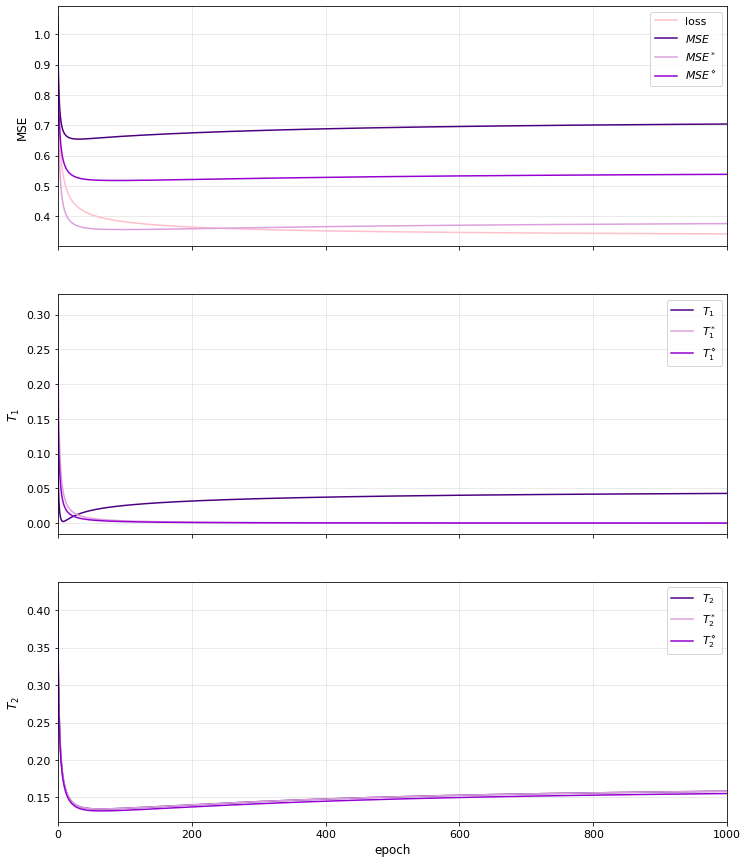

In [45]:
MSE = []
MSE_star =[]
MSE_diamond =[]

for i in range(3000):
    MSE.append(term_I_tab[i] + term_II_tab[i] + 1.0 - term_IV_tab[i])
    MSE_star.append(term_I_star_tab[i] + term_II_star_tab[i] + 1.0 - term_IV_star_tab[i])
    MSE_diamond.append(term_I_diamond_tab[i] + term_II_diamond_tab[i] + 1.0 - term_IV_diamond_tab[i])
    

fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

axs[0].plot(np.array(loss_tab)*10, color= 'pink', label = 'loss')
axs[0].plot(MSE, color= 'indigo', label = '$MSE$')
axs[1].plot(term_I_tab, color= 'indigo', label = '$T_1$')
axs[2].plot(term_II_tab, color= 'indigo', label = '$T_2$')

axs[0].plot(MSE_star, color= 'plum', label = '$MSE^*$')
axs[1].plot(term_I_star_tab, color= 'plum', label = '$T_1^*$')
axs[2].plot(term_II_star_tab, color= 'plum', label = '$T_2^*$')

axs[0].plot(MSE_diamond, color= 'darkviolet', label = '$MSE^\diamond$')
axs[1].plot(term_I_diamond_tab, color= 'darkviolet', label = '$T_1^\diamond$')
axs[2].plot(term_II_diamond_tab, color= 'darkviolet', label = '$T_2^\diamond$')

for ax in axs:
    ax.grid(True, color='gray', alpha = 0.2)
    ax.legend(fontsize=11)
    ax.tick_params(axis='both', labelsize=11)

axs[0].set_ylabel('MSE', fontsize=12)
axs[1].set_ylabel('$T_1$',fontsize=12)
axs[2].set_ylabel('$T_2$',fontsize=12)
axs[-1].set_xlabel('epoch',fontsize=12)
axs[-1].set_xlim(0,1000)

In [46]:
df = pd.DataFrame()
df['loss'] = loss_tab
df['train_accuracy'] = train_accuracy_tab
df['test_accuracy'] = test_accuracy_tab

df['w1_mean'] = w1_mean_tab
df['w1_std'] = w1_std_tab
df['w2_mean'] = w2_mean_tab
df['w2_std'] = w2_std_tab

df['MSE'] = MSE
df['term_I'] = term_I_tab
df['term_II'] = term_II_tab
df['term_IV'] = term_IV_tab

df['MSE_star'] = MSE_star
df['term_I_star'] = term_I_star_tab
df['term_II_star'] = term_II_star_tab
df['term_IV_star'] = term_IV_star_tab

df['MSE_diamond']= MSE_diamond
df['term_I_diamond'] = term_I_diamond_tab
df['term_II_diamond'] = term_II_diamond_tab
df['term_IV_diamond'] = term_IV_diamond_tab

df.to_csv('terms_100.csv')